# Practical Session 2 - Solutions
### Kernel Methods for Machine Learning

Written by Yunlong Jiao / Romain Menegaux, 21 June 2022

**To access this notebook:**

In your terminal:

1st download:
`git clone https://github.com/rmenegaux/kernels-AMMI-2022`

To get the latest version:
- Go to the directory `cd kernels-AMMI-2022`
- Run `git pull origin`

In [1]:
# setup
import numpy as np

In [2]:
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
import sklearn
from sklearn import linear_model as lm
sklearn.__version__

'1.0.2'

***
## Tasks

1. Implement (naive) solvers to Ridge Regression, Weighted Ridge Regression and Logistic Ridge Regression (using Iteratively Reweighted Least Squares). See notes for the mathematical derivation.
2. Simulate some toy data to check if our solvers give correct solutions.

***
### Ridge Regression (RR)

Given $X \in \mathbb{R}^{n \times p}$ and $y \in \mathbb{R}^n$, solve
$$
\min_{\beta \in \mathbb{R}^p} J(\beta) = \frac{1}{n} \|y - X \beta\|^2 + \lambda \|\beta\|^2 \,.
$$

Step 1: Compute $\nabla J$, and write the condition $\nabla J(\beta^{ridge}) = 0$

**Solution**
The gradient (Jacobian) of the objective is:
$$\nabla f(\beta) = \frac{2}{n}X^\top(X\beta - y) + 2\lambda \beta$$

The optimal solution verifies:
<font color='green'>
$$\nabla f(\beta) = 0 \iff (X^\top X + n\lambda I)\beta = X^\top y$$
</font>

$\|y - X \beta\|^2 = (X \beta - y)^\top(X \beta - y)$

In [4]:
# Ridge Regression (RR)
def solveRR(y, X, lam):
    n, p = X.shape
    assert (len(y) == n)
    
    A = X.T.dot(X)
    # Adjust diagonal due to Ridge
    # A[np.diag_indices_from(A)] += lam * n
    A += n * lam * np.eye(p)
    b = X.T.dot(y)
    # Hint:
    beta = np.linalg.solve(A, b)
    # Finds solution to the linear system Ax = b
    return (beta)

### Evaluation of our Ridge Regression solver:
#### One-dimensional data
(for visualization purposes)

In [5]:
np.random.seed(42)
n = 100
X = np.random.rand(n)
beta_star = 0.8
y = X * beta_star + 0.1 * np.random.normal(0, 1, n)
X = X[:, None] # Make X 2-dimensional to ensure consistency with rest of notebook

lam = 0
beta_hat = solveRR(y, X, lam)

print(beta_hat)

[0.78678556]


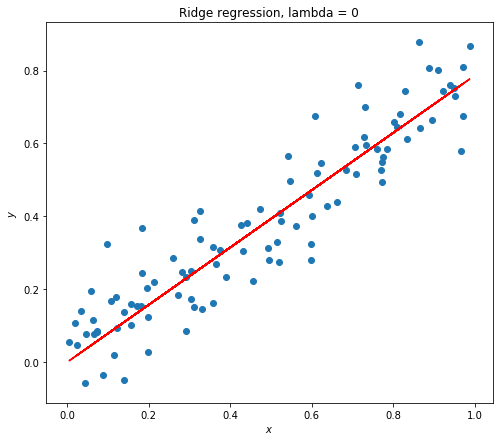

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,7))
plt.title('Ridge regression, lambda = {}'.format(lam))
plt.scatter(X, y)
plt.plot(X, X * beta_hat, c='r')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

#### Evaluation on p-dimensional data
---

In [7]:
# Toy data
np.random.seed(42) # for reproducibility
n = 100 # number of samples
p = 10 # number of features
X = np.random.normal(0, 1, (n, p))
X = sklearn.preprocessing.scale(X) # scale to 0 mean and 1 standard deviation
beta_star = np.random.normal(0, 1, p)
# y = X * beta + noise
y = X.dot(beta_star) + 0.2 * np.random.normal(0, 1, n) 

def compare(beta1, beta2):
    print('''
Our solver:
{}
Scikit-learn:
{}

Difference between the two:
{:.1e}
        '''.format(beta1.round(2), beta2.round(2), float(np.sum((beta1-beta2)**2)))
    )

In [8]:
lam = 0.1

# Our solver
beta1 = solveRR(y, X, lam)

# Python solver
alpha = lam * X.shape[0]
model = lm.Ridge(alpha=alpha, fit_intercept=False, normalize=False)
beta2 = model.fit(X, y).coef_

# Check
compare(beta1, beta2)


Our solver:
[ 1.28  0.79  0.05 -0.55  0.65  0.33  0.77  0.63  0.97 -0.53]
Scikit-learn:
[ 1.28  0.79  0.05 -0.55  0.65  0.33  0.77  0.63  0.97 -0.53]

Difference between the two:
2.0e-31
        


/Users/romainmenegaux/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


***
### Weighted Ridge Regression (WRR)

Given $X \in \mathbb{R}^{n \times p}$ and $y \in \mathbb{R}^n$, and weights $w \in \mathbb{R}^n_+$, solve
$$
\min_{\beta \in \mathbb{R}^p} \frac{1}{n} \sum_{i=1}^n w_i (y_i - \beta^\top x_i)^2 + \lambda \|\beta\|^2 \,.
$$

**Goal:** Express the objective as a regular Ridge Regression (RR)

Since the weights $w_i$ are non-negative, we can pull $w_i$ inside the parenthesis:
$$\sum_{i=1}^n w_i (y_i - \beta^\top x_i)^2 = \sum_{i=1}^n  (\sqrt{w_i}y_i - \beta^\top \sqrt{w_i} x_i)^2$$

This is a regular Ridge Regression (RR)!

with <font color='green'> $y_i' = \sqrt{w_i}y_i$</font> and <font color='green'>$x_i' = \sqrt{w_i}x_i$ </font>
$$$$

#### In matrix form:

Introducing the diagonal matrix $W = \mathrm{diag}(w_1, ..., w_n)$, we can rewrite the objective
$$\sum_{i=1}^n w_i (y_i - \beta^\top x_i)^2 = (Y - X\beta)^\top W (Y - X\beta)$$

We now write $W = W^\frac{1}{2}W^\frac{1}{2} = (W^\frac{1}{2})^\top W^\frac{1}{2}$, where $W^\frac{1}{2} = \mathrm{diag}(\sqrt{w_1}, ..., \sqrt{w_n})$
$$$$

The objective becomes:
$$
\frac{1}{n} (W^\frac{1}{2}Y - W^\frac{1}{2}X\beta)^\top  (W^\frac{1}{2}Y - W^\frac{1}{2}X\beta) + \lambda \|\beta\|^2 = \frac{1}{n} \|Y' - X'\beta\|^2 + \lambda \|\beta\|^2 \,
$$
with <font color='green'>$Y' = W^\frac{1}{2} Y$</font> and <font color='green'>$X' = W^\frac{1}{2} X$</font>

In [9]:
# Weighted Ridge Regression (WRR)
def solveWRR(y, X, w, lam):
    n, p = X.shape
    assert (len(y) == len(w) == n)

    w_sqrt = np.sqrt(w)
    
    y1 = w_sqrt * y
    X1 = X * w_sqrt[:, None] 
    # Or X1 = np.diag(w_sqrt) @ X # (Less efficient)

    # Hint:
    # Find y1 and X1 such that:
    beta = solveRR(y1, X1, lam)
    return (beta)

**Try it out:**

In [10]:
lam = 0.1
w = np.random.rand(len(y))

# Our solver
beta1 = solveWRR(y, X, w, lam)

# Python solver
alpha = lam * X.shape[0]
model = lm.Ridge(alpha=alpha, fit_intercept=False, normalize=False)
beta2 = model.fit(X, y, sample_weight=w).coef_

# Check
compare(beta1, beta2)


Our solver:
[ 1.22  0.69  0.05 -0.5   0.6   0.27  0.66  0.6   0.86 -0.51]
Scikit-learn:
[ 1.22  0.69  0.05 -0.5   0.6   0.27  0.66  0.6   0.86 -0.51]

Difference between the two:
2.1e-31
        


/Users/romainmenegaux/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


***
## Logistic Ridge Regression (LRR)
----

Given $X \in \mathbb{R}^{n \times p}$ and $y \in \{-1,+1\}^n$, solve
$$
\min_{\beta \in \mathbb{R}^p} \frac{1}{n} \sum_{i=1}^n \log (1+e^{-y_i \beta^\top x_i}) + \lambda \|\beta\|^2 \,.
$$

Let $\sigma(x) = \frac{1}{1 + e^{-x}}$ be the sigmoid function.

**Exercise:** Compute $\sigma'(x)$

**Solution**: $$\sigma'(x) = \frac{e^{-x}}{(1+e^{-x})^2} = \frac{1}{1+e^{-x}} - \frac{1}{(1+e^{-x})^2} = \sigma(x)(1-\sigma(x)) = \sigma(x)\sigma(-x)$$

Rewriting $J$:
$$
J(\beta) = - \frac{1}{n} \sum_{i=1}^n {\log(\sigma(y_i\beta^\top x_i))} + \lambda \|\beta\|^2 \,.
$$

**Exercise:** Compute its gradient $\nabla J$, and its Hessian $\nabla^2 J$
$$$$

#### Computing the gradient:
$$
\nabla J(\beta) = - \frac{1}{n} \sum_{i=1}^n {y_i \sigma(-y_i\beta^\top x_i) x_i} + 2\lambda \beta \,.
$$

#### Hessian matrix:
$$
\nabla^2 J(\beta) = \nabla \left(\nabla J(\beta)\right)
$$

$$
\nabla^2 J(\beta) = - \frac{1}{n} \sum_{i=1}^n {\sigma(y_i\beta^\top x_i)\sigma(-y_i\beta^\top x_i) x_i x_i^\top} + 2\lambda I \,
$$

Define $w_i = \sigma(y_i\beta^\top x_i)\sigma(-y_i\beta^\top x_i)$ and $W = \mathrm{diag}(w_1, ..., w_n)$
<font color='green'>
$$
\nabla^2 J(\beta) = - \frac{1}{n} X^\top W X + 2\lambda I \,
$$
</font>

### Gradient descent

- Initialize $\beta^{old} = \beta_0$
- Repeat until convergence: $$
\beta^{new} \leftarrow \beta^{old} - h \nabla J(\beta^{old})
$$
where $h$ is the step size (learning rate)

Under some conditions on $J$ (for example if $J$ is *convex* and $\nabla J$ is Lipschitz), and with an appropriate step-size $h$, this algorithm converges to a point $\beta^*$ such that $\nabla J(\beta^*) = 0$  

### Implementation of Logistic Ridge Regression with Gradient Descent
---

In [11]:
# Logistic Ridge Regression (LRR) with gradient descent (GD)
def solveLRR_gradient(y, X, lam, h=0.01, max_iter=500, eps=1e-12):
    '''
    lam: Regularization parameter
    max_iter: Max number of iterations of gradient descent
    eps: Tolerance for stopping criteria 
    '''
    n, p = X.shape
    assert (len(y) == n)
    
    beta_old = np.zeros(p)
    
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
            
    for i in range(max_iter):
        # yi beta^T xi
        f = (X * y[:, None]).dot(beta_old)
        gradient = - 1 / n * (y * sigmoid(-f)).dot(X)
        gradient += 2 * lam * beta_old
        
        # Step
        beta_new = beta_old - h * gradient
        
        if np.sum((beta_new-beta_old)**2) < eps:
            break
        beta_old = beta_new
    #         
    return (beta_new)

**Try it out:**

In [12]:
y_bin = np.sign(y) # Binarize targets
lam = 0.1

# Our solver
beta_gradient = solveLRR_gradient(y_bin, X, lam, h=.1, max_iter=5000)

# Python solver
alpha = 2 * lam * X.shape[0]
model = lm.LogisticRegression(C=1/alpha, fit_intercept=False)
beta_sklearn = model.fit(X, y_bin).coef_

# Check
compare(beta_gradient, beta_sklearn)


Our solver:
[ 0.5   0.32 -0.09 -0.17  0.27  0.15  0.36  0.32  0.3  -0.39]
Scikit-learn:
[[ 0.5   0.32 -0.09 -0.17  0.27  0.15  0.36  0.32  0.3  -0.39]]

Difference between the two:
8.9e-10
        


### Solving for optimal $\beta$ using Newton-Raphson
$$
\beta^{new} \leftarrow \beta^{old} - \left(\nabla^2 J(\beta^{old})\right)^{-1} \nabla J(\beta^{old})
$$

Show that each step is equivalent to solving a weighted ridge regression (WRR). Hence we can compute $\beta$ without inverting the Hessian.


<font color='green'>Quadratic approximation to $J$</font>:

$$
J(\beta) \approx J_q(\beta) = J(\beta^{old}) + (\beta - \beta^{old})^\top \nabla J(\beta^{old}) + \frac{1}{2} (\beta - \beta^{old})^\top \nabla^2 J(\beta^{old}) (\beta - \beta^{old})
$$

**Note:** *In one dimension:*
$$
f(x) \approx f(x_0) + f'(x_0)(x-x_0) + \frac{1}{2}f"(x_0)(x-x_0)^2
$$

- **Step 1**: Show that $$\min_\beta J_q(\beta) = \beta^{new} $$


**Solution**: We show that $\min_\beta J_q(\beta) = \beta^{old} - \left(\nabla^2 J(\beta^{old})\right)^{-1} \nabla J(\beta^{old}) = \beta^{new}$

*proof*: $$\nabla J_q(\beta) = \nabla J(\beta^{old}) + \nabla^2 J(\beta^{old}) (\beta - \beta^{old})$$
$$\nabla J_q(\beta) = 0 \iff \beta = \beta^{old} - \left(\nabla^2 J(\beta^{old})\right)^{-1} \nabla J(\beta^{old})$$

- **Step 2**: Show that $J_q$ is a WRR objective -- find $W$, $z$ such that:
<font color='green'>
$$
2J_q(\beta) = (z - X\beta)^\top W (z - X\beta) + 2\lambda \|\beta\|^2 + \mathrm{C}
$$
</font>

#### Solution:

Let us write all the terms in $J_q$ that depend on $\beta$:
$$$$

- $\beta^\top \nabla J(\beta^{old}) = -\frac{1}{n} \beta^\top X^\top P(\beta^{old}) y + 2\lambda \beta^\top \beta^{old}$
- -$\beta^\top \nabla^2 J(\beta^{old}) \beta^{old} = -\frac{1}{n} \beta^\top X^\top W(\beta^{old}) X \beta^{old} - 2\lambda \beta^\top \beta^{old}$
- $\frac{1}{2}\beta^\top \nabla^2 J(\beta^{old}) \beta = \frac{1}{2n} \beta^\top X^\top W(\beta^{old}) X \beta + \lambda \beta^\top \beta$

Putting it all together:
$$2J_q(\beta) = \frac{1}{n} \beta^\top X^\top W X \beta - \frac{2}{n} \beta^\top X^\top W \left(X \beta^{old} + W^{-1}Py\right) + 2\lambda \|\beta\|^2 + \mathrm{Constant}$$

We now define $z = X \beta^{old} + W^{-1}Py$ and we can rewrite $J_q(\beta)$ as:

<font color='green'>
$$
2J_q(\beta) = (z - X\beta)^\top W (z - X\beta) + 2\lambda \|\beta\|^2 + \mathrm{C}
$$
</font>

We recognize here a **weighted ridge regression!**

### Implementation of Logistic Ridge Regression with Newton-Raphson method
---

***
#### Recap for IRLS (code):

- Set:
    - $f_i = (\beta^{old})^\top x_i$
    - $W = \mathrm{diag}\left[\sigma(f_i)\sigma(-f_i)\right] = \mathrm{diag}\left[\sigma(f_1)\sigma(-f_1), ..., \sigma(f_n)\sigma(-f_n)\right]$
    - $z_i = f_i + \frac{y_i} {\sigma(y_i f_i)}$

    *(You can check that $\frac{-\sigma(y_i f_i)}{\sigma(f_i)\sigma(-f_i)} = \frac{1} {\sigma(y_i f_i)}$*)

- Call `solveWRR(z, W, X, 2`$\lambda$`)` at each update

- Stop when some criterion is reached, for example:
    - max number of iterations is reached
    - difference between 2 iterations is less than a threshold $\epsilon$: 
$$\|\beta^{new}-\beta^{old}\| < \epsilon$$
***

In [13]:
# Logistic Ridge Regression with Newton-Raphson
def solveLRR_newton(y, X, lam, max_iter=500, eps=1e-3):
    n, p = X.shape
    assert (len(y) == n)
    
    # Parameters
    max_iter = 500
    eps = 1e-3
    sigmoid = lambda a: 1/(1 + np.exp(-a))
    
    # Initialize
    beta = np.zeros(p)
            
    # Hint: Use IRLS
    for i in range(max_iter):
        beta_old = beta
        f = X.dot(beta_old)
        w = sigmoid(f) * sigmoid(-f)
        z = f + y / sigmoid(y*f)
        beta = solveWRR(z, X, w, 2*lam)
        # Break condition (achieved convergence)
        if np.sum((beta-beta_old)**2) < eps:
            break
    return (beta)

#### Evaluation

In [14]:
# Our solver
beta_newton = solveLRR_newton(y_bin, X, lam)

compare(beta_newton, beta_sklearn)


Our solver:
[ 0.5   0.32 -0.09 -0.17  0.27  0.15  0.36  0.32  0.3  -0.39]
Scikit-learn:
[[ 0.5   0.32 -0.09 -0.17  0.27  0.15  0.36  0.32  0.3  -0.39]]

Difference between the two:
2.4e-12
        


***
### Mini Data Challenge

We will try to predict whether patients have breast cancer.

We use scikit-learn's [breast cancer dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)

30 features, 569 samples, 2 labels ('malignant' or 'benign')

In [15]:
# Load data and split into training / validation sets
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# X, y = load_breast_cancer(return_X_y=True)
data = load_breast_cancer()
X, y = data['data'], data['target']
y = 2*y - 1 # transform from {0, 1} to {-1, 1}

# Hint: Scaling can be important
X = sklearn.preprocessing.scale(X)

# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
X.shape

(569, 30)

In [16]:
# Fit our model and compute its parameters
lam = 0.01
beta = solveLRR_newton(y_train, X_train, lam)

**Note:** Under the logistic model, <font color='green'>$\sigma(y_i\beta^\top x_i) = \mathbb{P}[y=y_i \mid x_i, \beta]$</font>

- $\mathbb{P}[y_i = 1 \mid x_i, \beta] = \sigma(\beta^\top x_i)$ (definition of the model)
- $\mathbb{P}[y_i = -1 \mid x_i, \beta] = 1 - \sigma(\beta^\top x_i) = \sigma(-\beta^\top x_i)$

In [17]:
# Compute predicted probabilities and classes
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

probas_pred = sigmoid(X_test.dot(beta))

y_pred = 2 * (probas_pred > 0.5) - 1

#### Performance evaluation
---

In [18]:
from sklearn.metrics import accuracy_score, roc_auc_score

print("Our model's performance:")
print('Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred)))
print('AUC: {:.2%}'.format(roc_auc_score(y_test, probas_pred)))

Our model's performance:
Accuracy: 98.40%
AUC: 99.85%


In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.97      0.99      0.98        67
           1       0.99      0.98      0.99       121

    accuracy                           0.98       188
   macro avg       0.98      0.98      0.98       188
weighted avg       0.98      0.98      0.98       188



#### Plotting the feature importances
---

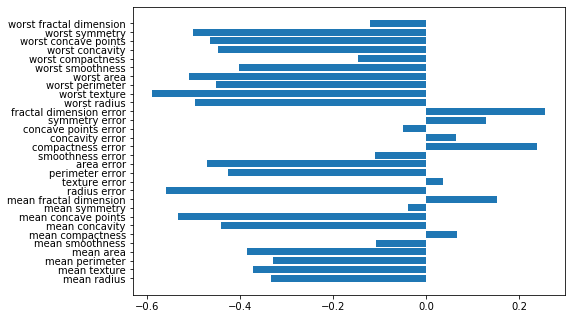

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
features = data['feature_names']
ax.barh(features, beta)
plt.show()